## 버전 확인

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 데이터 준비 및 확인

In [2]:
import pandas as pd

# 데이터를 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train : ", train_data.shape)
print("test : ", test_data.shape)

train_data.head()

train :  (150000, 3)
test :  (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성
- 중복 제거
- 결측값 제거
- 토큰화
- 불용어 제거
- 사전 word_to_index 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 중복 제거, 결측값 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # 토큰화, 불용어 제거
    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)
        
    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)
    
    # word_to_index 구성
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    
    ## <PAD>, <BOS>, <UNK>, <UNUSED>를 위한 인덱스 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
    
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
print("x train : ", len(x_train))
print("x test  : ", len(x_test))

x train :  146182
x test  :  49157


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
len(word_to_index)

10000

In [6]:
x_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 한다
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정

In [8]:
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산한다
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가

In [9]:
import tensorflow as tf
import keras

# 앞쪽(pre)에서 했을 때이다
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, 
    value=word_to_index["<PAD>"], 
    padding='pre', 
    maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test, 
    value=word_to_index["<PAD>"], 
    padding='pre', 
    maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [10]:
print('1번째 리뷰 문장 길이 : ', len(x_train[0]))
print('2번째 리뷰 문장 길이 : ', len(x_train[1]))

1번째 리뷰 문장 길이 :  41
2번째 리뷰 문장 길이 :  41


## 모델 구성 및 validation set 구성

In [11]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [12]:
vocab_size = 10000    # 어휘 사전 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [13]:
# model1 : LSTM(16), Dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.LSTM(16)(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model1 = keras.Model(inputs, outputs)

# model2 : Conv(16)x2, Dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.Conv1D(16, 7, activation='relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(16, 7, activation='relu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)

# model3 : GRU(16), Dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.GRU(16)(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model3 = keras.Model(inputs, outputs)

In [14]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 41, 16)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [15]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136 

In [16]:
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1632      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 161,777
Trainable params: 161,777
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련 개시

In [17]:
epochs = 20

- model1 : LSTM(16), Dense(8)

In [18]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 32s 7ms/step - loss: 0.4916 - accuracy: 0.7656 - val_loss: 0.3529 - val_accuracy: 0.8492
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3356 - accuracy: 0.8580 - val_loss: 0.3400 - val_accuracy: 0.8521
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3156 - accuracy: 0.8676 - val_loss: 0.3386 - val_accuracy: 0.8537
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3024 - accuracy: 0.8729 - val_loss: 0.3365 - val_accuracy: 0.8558
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2902 - accuracy: 0.8781 - val_loss: 0.3375 - val_accuracy: 0.8546
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2781 - accuracy: 0.8837 - val_loss: 0.3434 - val_accuracy: 0.8548
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2644 - accuracy: 0.8904 - val_loss: 0.3442 - val_accuracy: 0.8555
Epoch

In [19]:
results1 = model1.evaluate(x_test,  y_test, verbose=2)
print(results1)

1537/1537 - 3s - loss: 0.5076 - accuracy: 0.8389
[0.5076249837875366, 0.8388835787773132]


- model2 : Conv(16)x2, Dense(8)

In [20]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 17s 6ms/step - loss: 0.4922 - accuracy: 0.7531 - val_loss: 0.3482 - val_accuracy: 0.8486
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3253 - accuracy: 0.8612 - val_loss: 0.3376 - val_accuracy: 0.8529
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2922 - accuracy: 0.8780 - val_loss: 0.3346 - val_accuracy: 0.8562
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2651 - accuracy: 0.8920 - val_loss: 0.3384 - val_accuracy: 0.8540
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2355 - accuracy: 0.9071 - val_loss: 0.3502 - val_accuracy: 0.8538
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2064 - accuracy: 0.9210 - val_loss: 0.3790 - val_accuracy: 0.8486
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1770 - accuracy: 0.9351 - val_loss: 0.3999 - val_accuracy: 0.8447
Epoch

In [21]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)
print(results2)

1537/1537 - 3s - loss: 0.9965 - accuracy: 0.8191
[0.9964588284492493, 0.819069504737854]


- model3 : GRU(16), Dense(8)

In [22]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.5098 - accuracy: 0.7540 - val_loss: 0.3591 - val_accuracy: 0.8436
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3437 - accuracy: 0.8536 - val_loss: 0.3439 - val_accuracy: 0.8501
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3226 - accuracy: 0.8652 - val_loss: 0.3421 - val_accuracy: 0.8518
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3116 - accuracy: 0.8711 - val_loss: 0.3402 - val_accuracy: 0.8535
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3027 - accuracy: 0.8762 - val_loss: 0.3395 - val_accuracy: 0.8543
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2953 - accuracy: 0.8795 - val_loss: 0.3405 - val_accuracy: 0.8532
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2880 - accuracy: 0.8837 - val_loss: 0.3453 - val_accuracy: 0.8535
Epoch 

In [23]:
results3 = model3.evaluate(x_test,  y_test, verbose=2)
print(results3)

1537/1537 - 3s - loss: 0.4556 - accuracy: 0.8413
[0.4556051790714264, 0.8412637114524841]


## Loss, Accuracy 그래프 시각화

In [24]:
import matplotlib.pyplot as plt

def result_visualization(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='Training loss', color='orange', marker='o')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, label='Training acc', color='orange', marker='o')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### LSTM 모델

1537/1537 - 3s - loss: 0.5076 - accuracy: 0.8389
[0.5076249837875366, 0.8388835787773132]


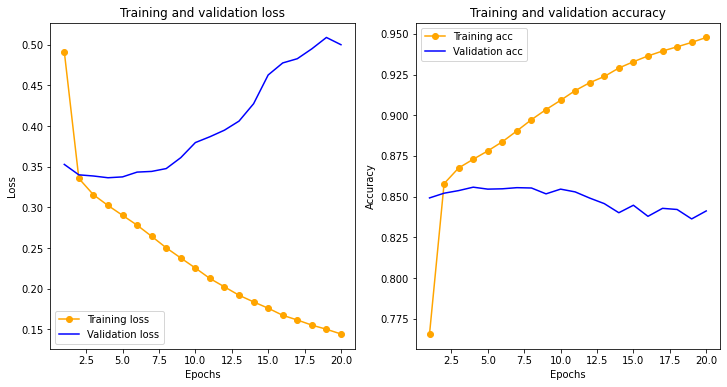

In [25]:
results1 = model1.evaluate(x_test,  y_test, verbose=2)
print(results1)
result_visualization(history1)

### 1D conv

1537/1537 - 2s - loss: 0.9965 - accuracy: 0.8191
[0.9964588284492493, 0.819069504737854]


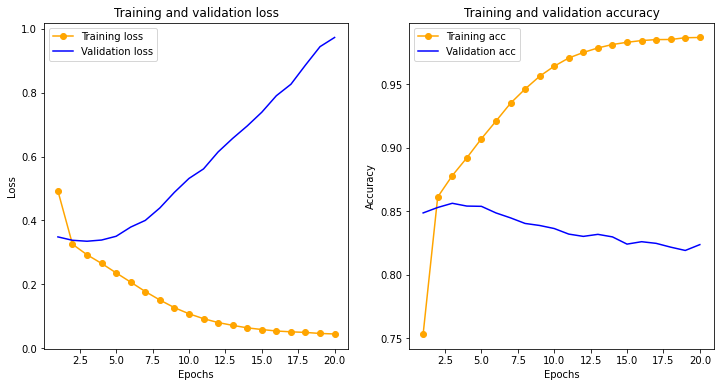

In [26]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)
print(results2)
result_visualization(history2)

### GRU

1537/1537 - 3s - loss: 0.4556 - accuracy: 0.8413
[0.4556051790714264, 0.8412637114524841]


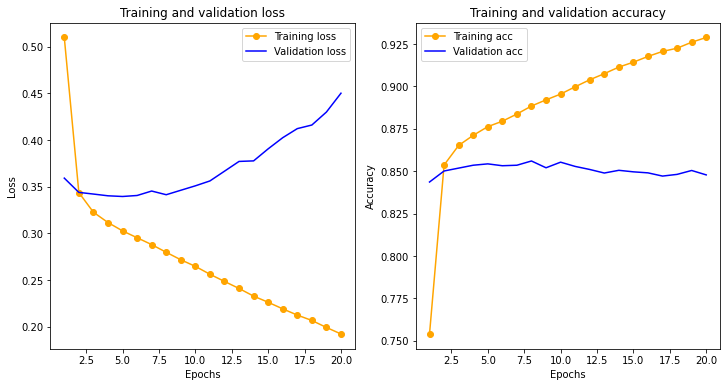

In [27]:
results3 = model3.evaluate(x_test,  y_test, verbose=2)
print(results3)
result_visualization(history3)

### 모델 3개 비교
- LSTM은 무난하게 결과가 나온 것 같다
- 1D conv는 두개에 비해 결과가 가장 안좋게 나왔다
- **GRU를 사용한게 가장 결과가 좋게 나왔다**

## 학습된 Embedding 레이어 분석

In [28]:
embedding_layer = model3.layers[1]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
import os
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['나']
vector

array([ 0.11928309,  0.00506194, -0.02043094, -0.00715565, -0.03663268,
        0.01556607, -0.06526763, -0.0128872 , -0.07849338,  0.01977997,
        0.01169229, -0.05662661, -0.00317013,  0.02537537, -0.06173559,
       -0.1405863 ], dtype=float32)

In [37]:
word_vectors.similar_by_word("슬픔")

[('종종', 0.9760951995849609),
 ('이편', 0.9731901288032532),
 ('원하', 0.972483217716217),
 ('바가지', 0.9676946997642517),
 ('최신', 0.9661560654640198),
 ('무척', 0.9656122922897339),
 ('수준급', 0.9648910760879517),
 ('숨막히', 0.9648504257202148),
 ('중후', 0.9646936655044556),
 ('슬펐', 0.9646919369697571)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기이다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [ ]:
# model4 : GRU(64), GRU(64), Dense(32), Dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(
        vocab_size, 
        word_vector_dim, 
        embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
        input_length=maxlen, 
        trainable=True)(inputs)

x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(64, return_sequences=False)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model4 = keras.Model(inputs, outputs)

In [ ]:
model4.summary()

In [ ]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20
              
history4 = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
results4 = model4.evaluate(x_test,  y_test, verbose=2)
print(results4)
result_visualization(history4)

- **드디어 정확도 85%를 넘겼다!!**

## 회고
여러 모델의 차이를 비교하고 분석하는 과정이 재밌었다  
근소한 차이로 정확도가 85%를 넘기지 못하고 있었는데 마지막에 85%를 도달할 수 있어서 뿌듯했다  
레이어를 추가하거나 파라미터를 더욱 다양하게 바꾸며 결과가 어떻게 변하는지 추가적인 실험을 하고 싶다